# Module 2 Final Project

## Introduction

In this Project, I will be using the Northwinds database from Microsoft to perform statistical analysis to assist in advising business recommendations for the company. Null and alternative hypothesis will be formed and tested. From the hypothesis testing, the null hypothesis will either be accepted or rejected.

<img src='Northwind_ERD.png'>

In [22]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
from sqlalchemy import inspect
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite")
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
inspector = inspect(engine)

print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']



## 1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
<br>
$H_o:$ Discounts have no effect on quantity of products customers order.

$H_0: \mu_1 = \mu_2$

$H_a:$ Discounts increase the mean quantity of products customers order.

$H_1: \mu_1 >  \mu_2$

I set my significance level to:

 $\alpha$ = 0.05
 
 A 2-sample independent t-test will be performed on the data to determine if we accept or reject the null hypothesis. If it is found that the discount does have an effect on the quantity, an ANOVA multiple comparison test will be used to determine if different discount levels have an effect on the quantity of products.

In [5]:
df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail ORDER BY Quantity', engine)
df.head()

,Quantity,Discount
0,1,0.0
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0


In [6]:
df.shape

(2155, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB


In [8]:
df.describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


In [9]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B5FE390>,
      dtype=object)

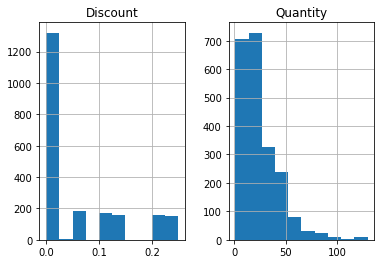

In [10]:
df.hist()

In [11]:
#Separating dataset into discount and non-discounted groups.
df_discount = df[df['Discount'] > 0]

In [12]:
df_no_discount = df[df['Discount'] == 0]

In [13]:
df_discount.describe()

,Quantity,Discount
count,838.000000,838.000000
mean,27.109785,0.144439
std,20.771439,0.071808
min,1.000000,0.010000
25%,12.000000,0.100000
50%,20.000000,0.150000
75%,36.000000,0.200000
max,130.000000,0.250000


In [14]:
df_no_discount.describe()

,Quantity,Discount
count,1317.000000,1317.0
mean,21.715262,0.0
std,17.507493,0.0
min,1.000000,0.0
25%,10.000000,0.0
50%,18.000000,0.0
75%,30.000000,0.0
max,130.000000,0.0


Based on initial observations of the datasets, the mean quantity for products with a discount is 27 while the mean quantity for products without a discount is 22. We can see the mean is already showing to be higher for the discounted quantities. We will now use testing to determine if this higher mean value is statistically significant.

An assumption made by the t-test is normality of distributions. We will look at the hisotgrams and check for normality with the Kolmogorov-Smirnov Test.

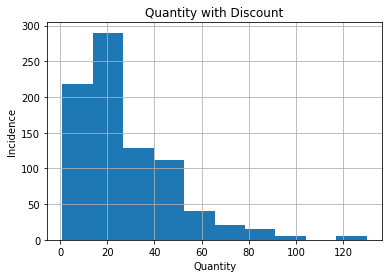

In [15]:
df_discount.Quantity.hist()
plt.title('Quantity with Discount')
plt.xlabel('Quantity')
plt.ylabel('Incidence')
plt.show()

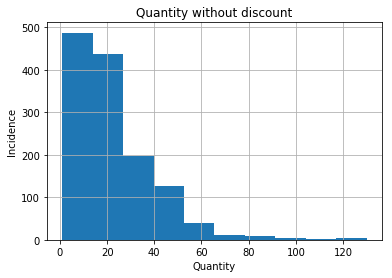

In [16]:
df_no_discount.Quantity.hist()
plt.title('Quantity without discount')
plt.xlabel('Quantity')
plt.ylabel('Incidence')
plt.show()

The histograms for both of the data sets do not appear to be normal. They both have positive skew.

In [17]:
import scipy.stats as stats
stats.kstest(df_discount.Quantity, 'norm')

KstestResult(statistic=0.9724765983620833, pvalue=0.0)

In [18]:
stats.kstest(df_no_discount.Quantity,'norm')

KstestResult(statistic=0.9673789492970751, pvalue=0.0)

A p-value of 0 in the KS test comparing the distributions to a normal distribution shows that the data is not a normal distribution. In order to run the t-test we must have a normal distribution, we will use the Central Limit Theorem to create a normal distribution of the sample means of the data.

In [19]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

def create_sample_distribution(data, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [20]:
# Creating sample distributions of the data
norm_discount = create_sample_distribution(df_discount.Quantity)
norm_no_discount = create_sample_distribution(df_no_discount.Quantity)

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


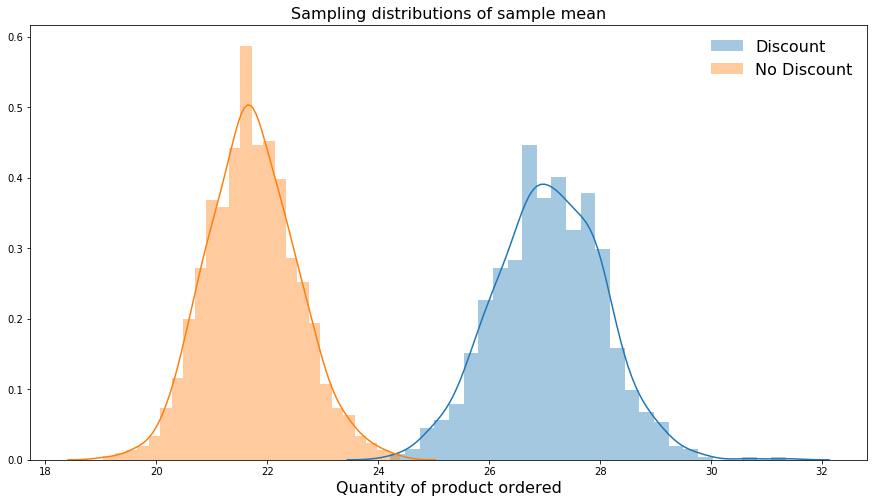

In [23]:
plt.figure(figsize = (15, 8))
sns.distplot(norm_discount, label='Discount')
sns.distplot(norm_no_discount, label='No Discount')
plt.title('Sampling distributions of sample mean', fontsize=16)
plt.xlabel('Quantity of product ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

After applying the central limit theorem, the distributions from both sample mean distributions are clearly normalized. The mean quantity of product ordered in the 'No Discount' distribution is visually lower than the 'Discount' group. Now the t-test can be performed.

In [24]:
from scipy.stats import ttest_ind
results = ttest_ind(norm_discount, norm_no_discount)
results

Ttest_indResult(statistic=133.50774894311908, pvalue=0.0)

After performing t-test comparing quantity of products from a discounted and non discounted group, it can be concluded that discounts do have an effect on the quantity of products and null hypothesis can be rejected. 
Due to the large sample size, the t-test may be giving a false positive. An effect size will be calculated to determine if the difference is meaningful, or just producing a significant result due to the large sample size.

In [25]:
def Cohen_d(group1, group2):

    diff = group1.mean()-group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1*var1+n2*var2) / (n1+n2)
  
    d = diff / np.sqrt(pooled_var)
    
    return d

# calculate Cohen's d for target and control samples
print("Cohen's d:" , Cohen_d(np.array(norm_discount), np.array(norm_no_discount)))

Cohen's d: 5.973635608077876


An effect size greater than 0.8 is considered to have be a large effect meaning a significant difference between groups. The effect size we calculated is 6.4. This is showing that discounts in fact do have a large effect on quantity of products ordered.

The next question we will investigate is if different discount levels have more of an effect on quantity of products ordered.

In [26]:
df_discount.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

In [27]:
df_discount['Quantity'].groupby(df_discount['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0


In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


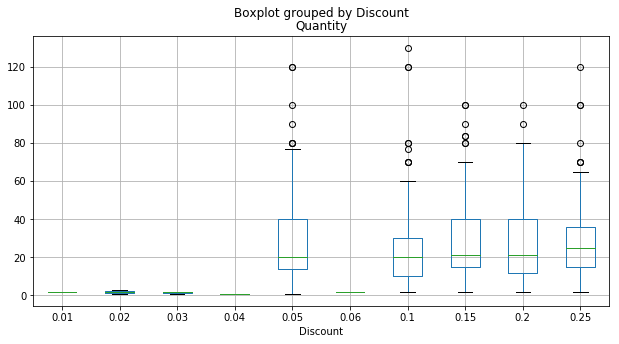

In [29]:
df_discount.boxplot('Quantity', by='Discount', figsize=(10, 5));

In [30]:
# wrap with C() to indicate categorical variable
results = ols('Quantity ~ C(Discount)', data=df).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


The results from the ANOVA test comparing multiple variables shows a p-value very close to zero. From this value, we can reject the null hypothesis and accept that there is a statistical difference when comparing the means of different discounts. The ANOVA test does not tell us which discount values have statistically different means than the no discount group. The Tukey test will be used to find out where the statistical difference is present.

In [31]:
mc = MultiComparison(df['Quantity'], df['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

Interpreting the Tukey test results is showing that we reject the null hypothesis and accept that there is a statistical significant difference in means between the no discount group and discounts of 5, 15, 20 and 25%. No statistical significant difference in means was present in the the discount groups of 1, 2, 3, 4, 6 or 10%. 

## 2. Do Customers in the US spend more per order than customers in other countries?

$H_o:$ Total Order Price for the US is the same as Total Order Price for other countries.

$H_0: \mu_1 = \mu_2$

$H_a:$ Total Order Price for the US is more than Total Order Price for other countries.

$H_1: \mu_1 >  \mu_2$

I set my significance level to:

 $\alpha$ = 0.05
 
 The test we will use if a 2 sample, 1 tailed t-test with unequal variance.

In [32]:
print(inspector.get_columns('Customer'))

[{'name': 'Id', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'CompanyName', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ContactName', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ContactTitle', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Address', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'City', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Region', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'PostalCode', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'aut

In [33]:
print(inspector.get_columns('OrderDetail'))

[{'name': 'Id', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'OrderId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ProductId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'UnitPrice', 'type': DECIMAL(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Quantity', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Discount', 'type': FLOAT(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [34]:
df = pd.read_sql_query('''SELECT o.id, c.Country, d.Quantity, d.UnitPrice
             FROM Customer c JOIN "Order" o
             ON C.Id = o.CustomerId
             JOIN OrderDetail d
             ON o.Id = d.OrderId
             GROUP By o.Id''', engine)
df.head()

,Id,Country,Quantity,UnitPrice
0,10248,France,5,34.8
1,10249,Germany,40,42.4
2,10250,Brazil,15,16.8
3,10251,France,20,16.8
4,10252,Belgium,40,27.2


In [35]:
df.shape

(801, 4)

In [36]:
#Creating column of Total order price by multiplying quantity of product by the unit price.
df['Total_Order_Price'] = df.Quantity * df.UnitPrice
df.head()

,Id,Country,Quantity,UnitPrice,Total_Order_Price
0,10248,France,5,34.8,174.0
1,10249,Germany,40,42.4,1696.0
2,10250,Brazil,15,16.8,252.0
3,10251,France,20,16.8,336.0
4,10252,Belgium,40,27.2,1088.0


In [37]:
# Separating data set into USA and other countries.
df_USA = df[df['Country'] == 'USA']
df_others = df[df['Country'] != 'USA']

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


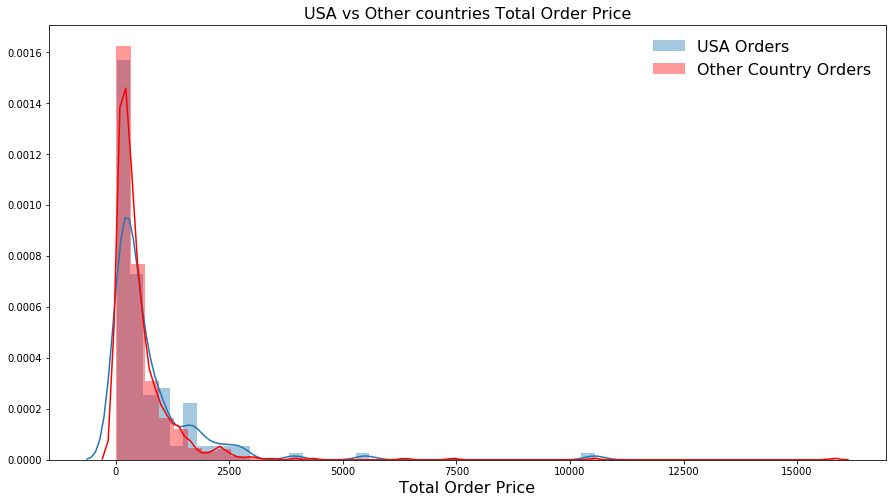

In [40]:
plt.figure(figsize = (15, 8))
sns.distplot(df_USA['Total_Order_Price'], label='USA Orders')
sns.distplot(df_others['Total_Order_Price'], label='Other Country Orders', color = 'red')
plt.title('USA vs Other countries Total Order Price', fontsize=16)
plt.xlabel('Total Order Price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

Visualizing the distribution of the two datasets shows the distributions have positive skew. Histograms will also be examined.

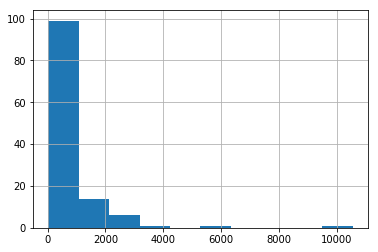

In [41]:
df_USA.Total_Order_Price.hist()

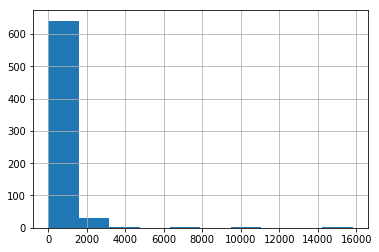

In [42]:
df_others.Total_Order_Price.hist()

In [43]:
stats.kstest(df_USA.Total_Order_Price, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [44]:
stats.kstest(df_others.Total_Order_Price, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

The histograms and KS test is also showing the datasets are skewed when compared to a normal distribution. Sample distributions of the sample means will be created in order to perform a t-test comparing the data.

In [46]:
df_USA.describe()

,Id,Quantity,UnitPrice,Total_Order_Price
count,122.000000,122.000000,122.000000,122.000000
mean,10667.008197,27.377049,28.620246,766.242049
std,234.807588,25.177823,34.978360,1225.140608
min,10262.000000,2.000000,2.000000,26.000000
25%,10479.750000,10.000000,13.000000,190.875000
50%,10671.500000,20.000000,20.850000,377.400000
75%,10854.250000,34.250000,34.800000,922.500000
max,11077.000000,120.000000,263.500000,10540.000000


In [47]:
df_others.describe()

,Id,Quantity,UnitPrice,Total_Order_Price
count,679.000000,679.000000,679.000000,679.000000
mean,10660.569956,22.123711,24.438513,557.113608
std,241.874783,17.641447,24.157560,960.445909
min,10248.000000,1.000000,2.000000,12.500000
25%,10450.500000,10.000000,12.000000,146.750000
50%,10655.000000,20.000000,18.000000,315.000000
75%,10871.500000,30.000000,33.250000,630.000000
max,11076.000000,130.000000,263.500000,15810.000000


In [48]:
norm_USA = create_sample_distribution(df_USA['Total_Order_Price'])
norm_others = create_sample_distribution(df_others['Total_Order_Price'])

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


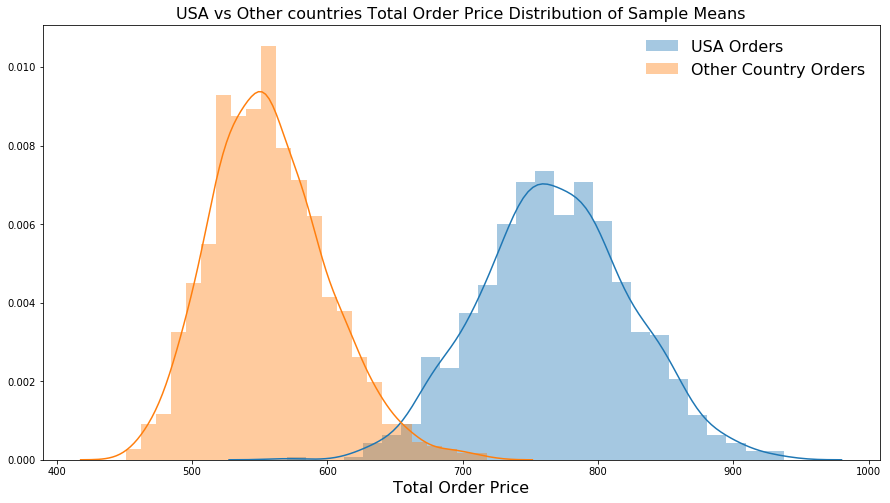

In [49]:
plt.figure(figsize = (15, 8))
sns.distplot(norm_USA, label='USA Orders')
sns.distplot(norm_others, label='Other Country Orders')
plt.title('USA vs Other countries Total Order Price Distribution of Sample Means', fontsize=16)
plt.xlabel('Total Order Price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

In [50]:
results = ttest_ind(norm_USA, norm_others, equal_var= False)
results

Ttest_indResult(statistic=95.39910384713015, pvalue=0.0)

In [51]:
# calculate effect size
print("Cohen's d:" , Cohen_d(np.array(norm_USA), np.array(norm_others)))

Cohen's d: 4.2685124139328625


Results form the 2-sample t-test show a p-value of 0.0 which rejects the null hypothesis. Since this is a 1 tailed test, the p-value should be divided by 2 which is also 0.  This is interpreted as the mean of the total order price from the USA is statistically significant higher than the mean of the total population.  The effect size of 4.3 is considered a large effect showing a significant difference between the groups.

## 3. Do employees in the US sell more orders than employees in UK?

### Hypothesis

$H_0$: Employees in the US sell same amount of orders as employees in the UK

 $H_0: \mu_1 = \mu_2$

$H_1$: Employees in the US sell more than employees in the UK.

 $H_1: \mu_1 >  \mu_2$

I set my significance level to:

 $\alpha$ = 0.05

Since we are comparing 2 means to determine if one is statistically greather than the other, we will test using a 2 sample 1 tailed test.

In [52]:
q = """SELECT e.LastName, e.FirstName, e.Country, Count(o.id) as num_orders \
FROM [Order] o INNER JOIN employee e on o.employeeid = e.ID \
GROUP BY e.LastName ORDER BY num_orders DESC"""

df = pd.read_sql_query(q, engine)
df

,LastName,FirstName,Country,num_orders
0,Peacock,Margaret,USA,156
1,Leverling,Janet,USA,127
2,Davolio,Nancy,USA,123
3,Callahan,Laura,USA,104
4,Fuller,Andrew,USA,96
5,King,Robert,UK,72
6,Suyama,Michael,UK,67
7,Dodsworth,Anne,UK,43
8,Buchanan,Steven,UK,42


Based on initial observation, the 5 employees in the US appear to sell more orders than the 4 employees in the UK. We will do tests to determine if it is a statistically significant difference.

In [53]:
# Form 2 groups
df_US_employees = df[df['Country'] == 'USA']
df_UK_employees = df[df['Country'] == 'UK']

In [54]:
np.var(df_US_employees['num_orders'])

435.76000000000005

In [55]:
np.var(df_UK_employees['num_orders'])

185.5

In [56]:
results = ttest_ind(df_US_employees['num_orders'], df_UK_employees['num_orders'], equal_var= False)
results

Ttest_indResult(statistic=4.989276445572398, pvalue=0.001669680522976415)

In [57]:
# calculate effect size
print("Cohen's d:" , Cohen_d(np.array(df_US_employees['num_orders']), np.array(df_UK_employees['num_orders'])))

Cohen's d: 3.6192446448819933


Pvalue for ttest is 0.0017 will be divided by 2 due to 1 tailed test. This still produces a pvalue below the significance level of 0.05. We can reject the null hypothesis and state that US employees sell statistically more orders than employees from the UK. The effect size of 3.6 is considered a large effect.

## 4. Is there a Product Category that is purchased more with a discount?

### Hypothesis

$H_0$: All Product categories are purchased in the same quantity when the products are discounted.

 $H_0: \mu_1 = \mu_2$

$H_1$: A certain product category is purchased in higher quantities when it is discounted.

 $H_1: \mu_1 >  \mu_2$

I set my significance level to:

 $\alpha$ = 0.05

Since we are comparing multiple groups, we will use a multiple comparison ANOVA test.

In [58]:
df = pd.read_sql_query('''

                                SELECT CategoryID, OD.Quantity, OD.Discount FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                ORDER BY CategoryId

''', engine)
df.head()

,CategoryId,Quantity,Discount
0,1,42,0.00
1,1,15,0.15
2,1,20,0.00
3,1,6,0.00
4,1,50,0.20


In [59]:
df.shape

(2155, 3)

In [60]:
df.CategoryId.value_counts()

1    404
4    366
3    334
8    330
2    216
5    196
6    173
7    136
Name: CategoryId, dtype: int64

In [61]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [62]:
# Removing non-discounted items from dataset
df = df[df['Discount'] != 0.00]

In [63]:
df.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

In [64]:
df.shape

(838, 3)

In [65]:
df.CategoryId.value_counts()

1    158
4    142
8    135
3    134
2     85
6     76
5     63
7     45
Name: CategoryId, dtype: int64

In [66]:
df.groupby('CategoryId').mean()

,Quantity,Discount
CategoryId,,
1,27.949367,0.158228
2,29.470588,0.133765
3,24.537313,0.141940
4,29.464789,0.137746
5,24.396825,0.140952
6,28.802632,0.146711
7,24.066667,0.137333
8,26.044444,0.147259


In [67]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df         F    PR(>F)
C(CategoryId)  0.051426    7.0  1.429891  0.189751
Residual       4.264460  830.0       NaN       NaN


Performing the multisample ANOVA test comparing CategoryId and Discount we are getting a p-value of 0.189 which is greater than our significance level of 0.05. We fail to reject our null hypothesis of difference between product categories and discount.  Therefore, we conclude that all products are sold at statistically similar quantities when discounted.

## Conclusion

In summary, we find:

* There is strong statistical evidence for a difference in quantity of products sold that are discounted vs. not discounted.
* Discount Percentages of 5, 15, 20 and 25% were shown to have the greatest effect on quantity sold.
* Customers in the USA spend statistically significant more per order when compared to the orders of other countries.
* Employees in the USA sell statistically significant more orders than employees in the UK.
* When discounted, all product categories sell at similar quantities when compared to each other.

Future Work:

* Investigation should be done on which countries spend the least per order so marketing can focus on a specific area.
* Look into territories of UK employees to find out how they can increase there sales.
* Determine which products sell the best without discount to avoid unneccessary discounts.